In [1]:
# Imports here
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import helper
from collections import OrderedDict
import json

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

dir_dict = {'train': train_dir, 
        'valid': valid_dir, 
        'test' : test_dir}

In [3]:

train_transform = transforms.Compose(
    [
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


test_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

valid_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)




In [4]:
train_data = datasets.ImageFolder(train_dir, transform=train_transform)

test_data = datasets.ImageFolder(test_dir, transform=test_transform)

valid_data = datasets.ImageFolder(valid_dir, transform=valid_transform)

image_datasets = train_data

In [5]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)




In [7]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [8]:
device = torch.device("cuda")


In [9]:
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    



classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 1024)),
                          ('dropout', nn.Dropout(.20)),
                          ('relu1',nn.ReLU()),
                          ('fc2', nn.Linear(1024, 102)),
                          ('output', nn.LogSoftmax(dim=1))]))


model.classifier = classifier

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)


model = model.to(device)


/home/ubtadobres/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubtadobres/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
def train_model(model, criterion, optimizer, epochs = 1, device='cuda', ):

     

    steps = 2
    running_loss = 0
    print_every = 20
    for epoch in range(epochs):
        running_loss = 0
        for inputs, labels in trainloader:
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            torch.set_grad_enabled(True)
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()

            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in testloader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)

                        test_loss += batch_loss.item()

                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                print(
                    f"Epoch {epoch+1}/{epochs}.. "
                    f"Train loss: {running_loss/len(trainloader):.3f}.. "
                    f"Test loss: {test_loss/len(testloader):.3f}.. "
                    f"Test accuracy: {accuracy/len(testloader):.3f}")
            
                running_loss = 0
                model.train()
                
    return model

In [12]:
train_model(model, criterion, optimizer, epochs = 2, device='cuda')

Epoch 1/2.. Train loss: 0.474.. Test loss: 3.733.. Test accuracy: 0.182
Epoch 1/2.. Train loss: 0.349.. Test loss: 2.935.. Test accuracy: 0.321
Epoch 1/2.. Train loss: 0.269.. Test loss: 2.326.. Test accuracy: 0.450
Epoch 1/2.. Train loss: 0.230.. Test loss: 2.047.. Test accuracy: 0.491
Epoch 1/2.. Train loss: 0.198.. Test loss: 1.701.. Test accuracy: 0.554
Epoch 1/2.. Train loss: 0.174.. Test loss: 1.520.. Test accuracy: 0.608
Epoch 1/2.. Train loss: 0.161.. Test loss: 1.585.. Test accuracy: 0.595
Epoch 1/2.. Train loss: 0.159.. Test loss: 1.439.. Test accuracy: 0.623
Epoch 1/2.. Train loss: 0.155.. Test loss: 1.356.. Test accuracy: 0.640
Epoch 1/2.. Train loss: 0.168.. Test loss: 1.346.. Test accuracy: 0.626
Epoch 2/2.. Train loss: 0.081.. Test loss: 1.242.. Test accuracy: 0.655
Epoch 2/2.. Train loss: 0.125.. Test loss: 1.240.. Test accuracy: 0.661
Epoch 2/2.. Train loss: 0.126.. Test loss: 1.311.. Test accuracy: 0.669
Epoch 2/2.. Train loss: 0.116.. Test loss: 1.220.. Test accuracy

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:



model.class_to_idx = train_data.class_to_idx

torch.save({'class_to_idx' : model.class_to_idx, 
            'model_state_dict' : model.state_dict(),
            'classifier' : classifier,
            'optimizer_dict' : optimizer.state_dict()},
            'checkpoint.pth')

In [14]:
#Load checkpoint
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)

    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
    optimizer.load_state_dict(checkpoint['optimizer_dict'])
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model


In [15]:
#load check
model = load_checkpoint('checkpoint.pth')


In [16]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
#Preprocessing

def process_image(image_path):
    
    from PIL import Image

    img = Image.open(image_path)

    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))


    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224

    img = img.crop((left_margin, bottom_margin, right_margin, top_margin))

    img = np.array(img)/255

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean)/std

    img = img.transpose((2, 0, 1))

    return img

In [18]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.cpu()
    image = process_image(image_path)
    image = torch.from_numpy(image).type(torch.FloatTensor)
    image = image.unsqueeze(0)
    logps = model(image)
    prob = torch.exp(logps)
    top_p, top_class = prob.topk(topk, dim=1)
    
    classes = top_class[0].tolist()
    probs = top_p[0].tolist()
    return probs, classes 

In [19]:
predict('flower_data/test/67/image_07080.jpg', model)

([0.9995197057723999,
  0.00018978708249051124,
  0.00018750553135760128,
  6.639509956585243e-05,
  1.1382827324268874e-05],
 [66, 76, 0, 95, 87])

In [20]:
predict('flower_data/train/100/image_07898.jpg',model)

([0.9999749660491943,
  1.3059053344477434e-05,
  8.593200618634e-06,
  2.7354708436178043e-06,
  2.883838874367939e-07],
 [2, 26, 11, 83, 28])

In [21]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


In [22]:
img = process_image('imgshow.jpg')
imshow(img)

FileNotFoundError: [Errno 2] No such file or directory: 'imgshow.jpg'

In [23]:
def sanity_check(image_path, model):
    san_image = image_path
    san_name = cat_to_name[san_image.split('/')[2]] 
    top_p, top_class = predict(san_image, model)
    names = []
    
    
    inverted_class_to_idx = {model.class_to_idx[cl]: cl for cl in model.class_to_idx}
    mapped_classes = []
    for label in top_class:
        mapped_classes.append(inverted_class_to_idx[label])

    for c in mapped_classes:  
        names.append(cat_to_name[str(c)])
    
    fig, (ax1, ax2) = plt.subplots(figsize=(5, 9), ncols=1, nrows=2)

    img = process_image(san_image) 
    imshow(img, ax1)
    ax1.set_title(san_name)

    index = np.arange(len(mapped_classes))
    ax2.barh(names, top_p, align='center')
    
    
    
    
    

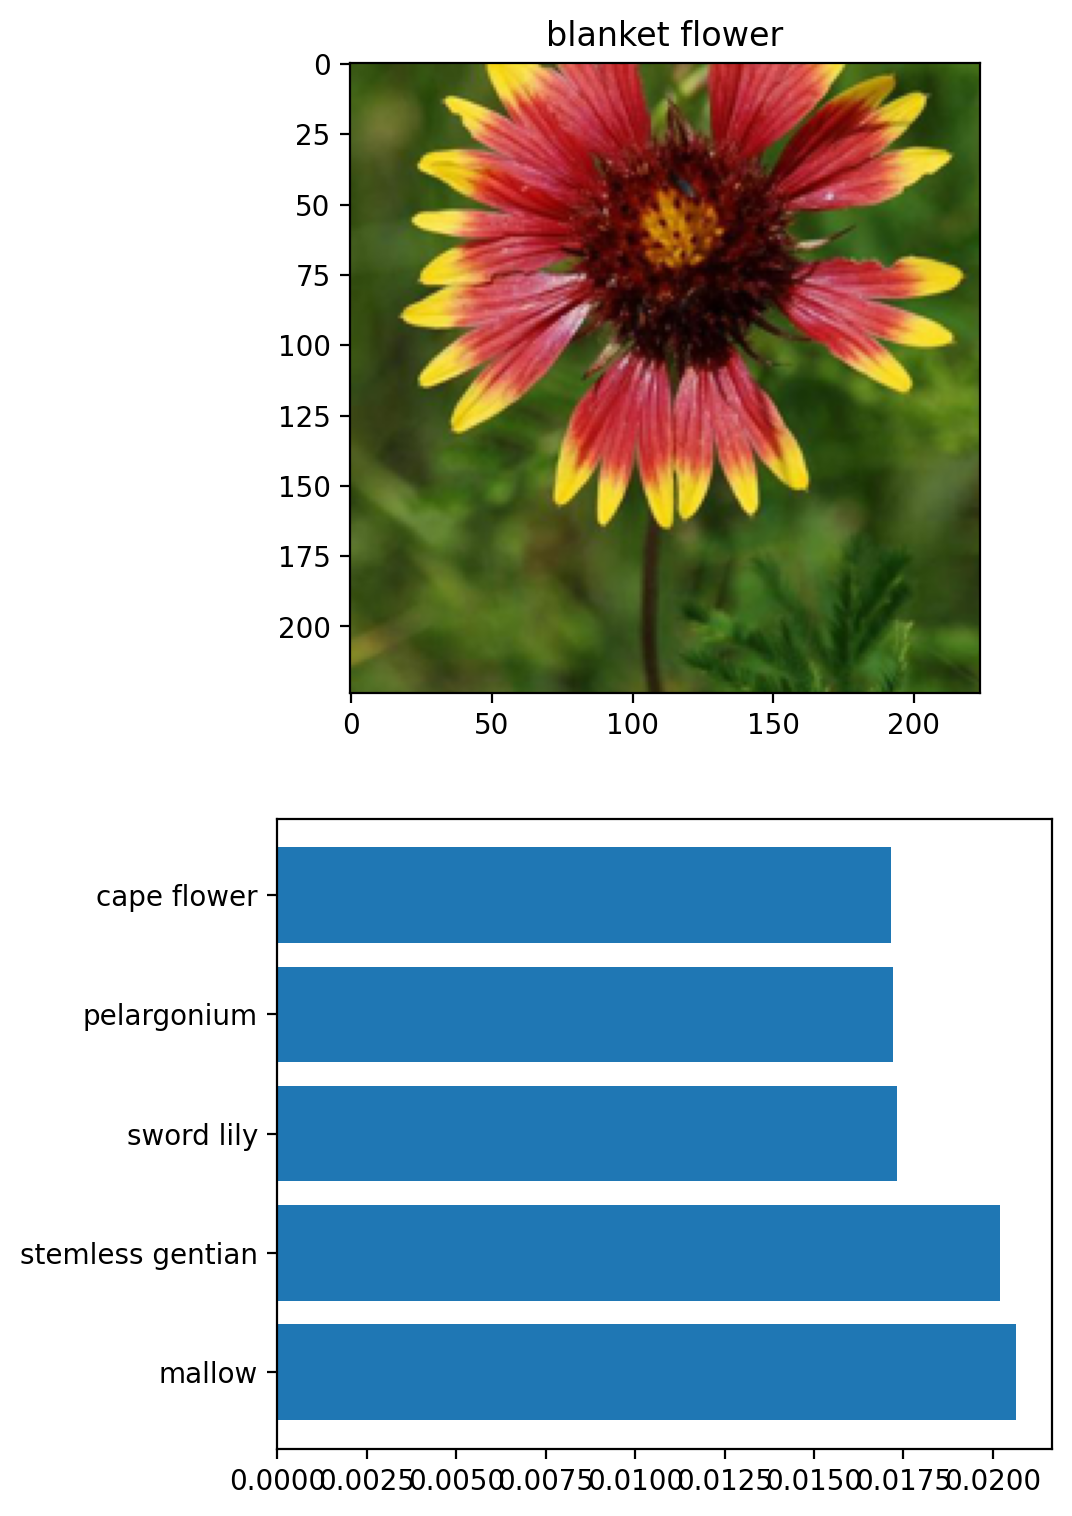

In [75]:
sanity_check('flower_data/train/100/image_07898.jpg',model)